### Plot Selected Features by Survival Outcomes

In this notebook we plot survival outcome (event/censored) and survival time for selected features. We examine:
- `age_at_hct`
- `comorbidity_score`
- `karnofsky_score`
- `hla_match_drb1_high`
- `hla_high_res_10`
- `race_group`

The first four features were identified as imortant via experiments with lasso regression. The feature `hla_high_res_10` is an overall measure of genetic compatibility of donor vs. recipient. Since one HLA match feature was identified as important, it seems reasonable to consider overall HLA match. Finall, race is relevant to our metric (risk score, stratified by race). The feature `hla_match_drb1_low`, which was also flagged as important, is not included. That feature is a less-sensitive measure of the same allele match as `hla_match_drb1_low`.

#### Load Data

In [3]:
# Import libraries and modules
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

In [47]:
df = pd.read_csv("../data/train_set.csv")
df['efs'] = df['efs'].replace({0:"Censored", 1:"Event"})

In [48]:
print("The training set has {} rows and {} columns".format(df.shape[0], df.shape[1]))

The training set has 23040 rows and 60 columns


#### Define Helper Functions to Plot Features

In [70]:
# Function that takes the name of 
# and produces a histogram of the number of 
# cases for each value of the feature, 
# broken down by efs (Event/Censored).

def hist_by_efs(feat_name, df=df, tick_angle = 0, figsize=(6, 3), discrete=True, bins='auto'):
    fig, ax = plt.subplots(figsize=figsize)
    sns.histplot(df, x = feat_name, hue='efs', discrete=discrete, multiple='stack', bins=bins,
                hue_order=['Censored', 'Event'])
    plt.xlabel(feat_name)
    plt.ylabel("Number of cases")
    plt.title("Number of cases by {}".format(feat_name))
    ax.tick_params(axis='x', rotation=tick_angle)
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    plt.show()

In [79]:
def scatter_by_efs_discrete(feat_name, df=df, tick_angle=0, figsize=(12, 3)):
    fig, ax = plt.subplots(figsize=figsize)
    sns.stripplot(data = df, x = feat_name, y = 'efs_time', hue='efs', jitter=0.3, alpha=0.3, )
    plt.tick_params(axis='x', rotation=tick_angle)
    plt.title("Scatter plot of {} vs. survival time".format(feat_name))
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

In [66]:
def scatter_by_efs_continuous(feat_name, df=df, tick_angle=0, figsize=(6, 3)):
    fig, ax = plt.subplots(figsize=figsize)
    sns.scatterplot(data = df, x = feat_name, y = 'efs_time', hue='efs', alpha=0.3)
    plt.tick_params(axis='x', rotation=tick_angle)
    plt.title("Scatter plot of {} vs. survival time".format(feat_name))
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

#### Plots for Selected Features

##### age_at_hct

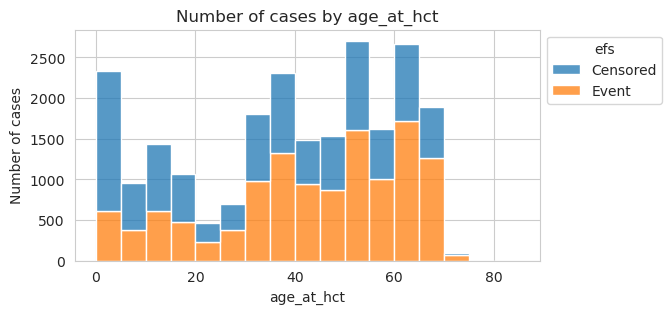

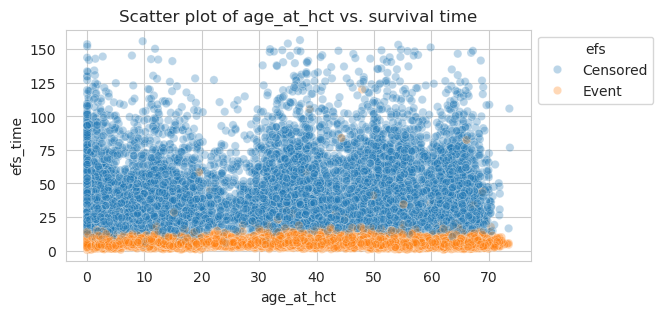

In [81]:
hist_by_efs('age_at_hct', discrete=False, bins=range(0, 90, 5))
scatter_by_efs_continuous('age_at_hct')

##### comorbidity_score

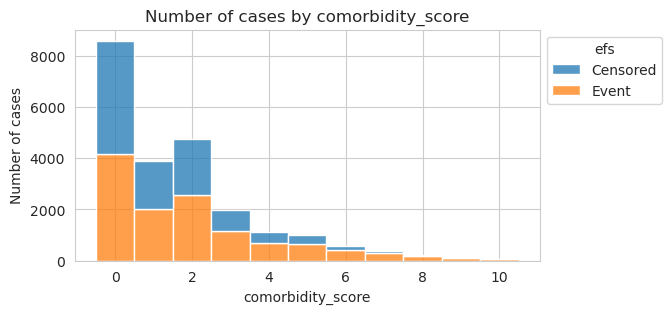

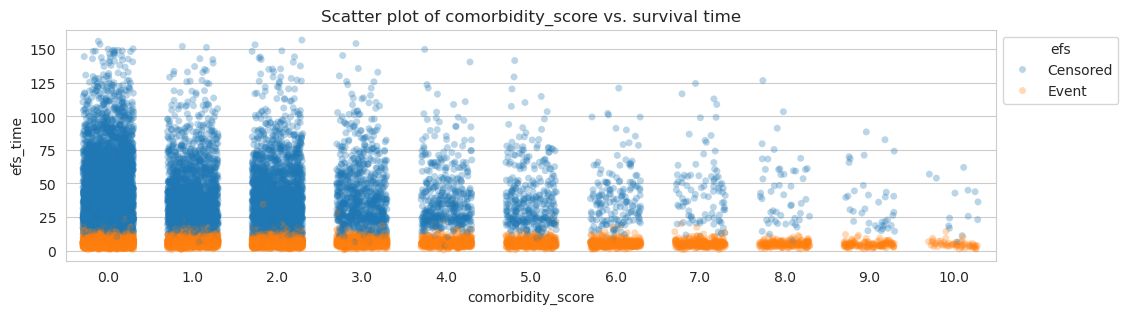

In [84]:
hist_by_efs('comorbidity_score')
scatter_by_efs_discrete('comorbidity_score')

##### karnofsky_score

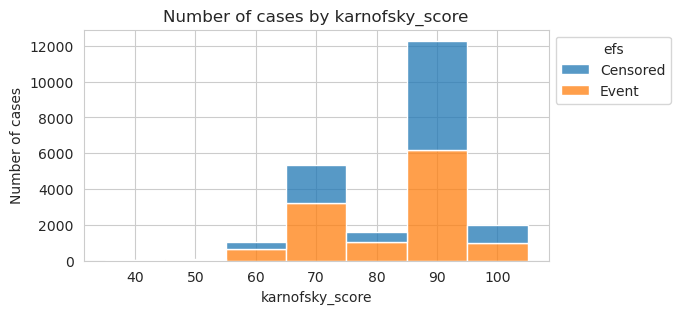

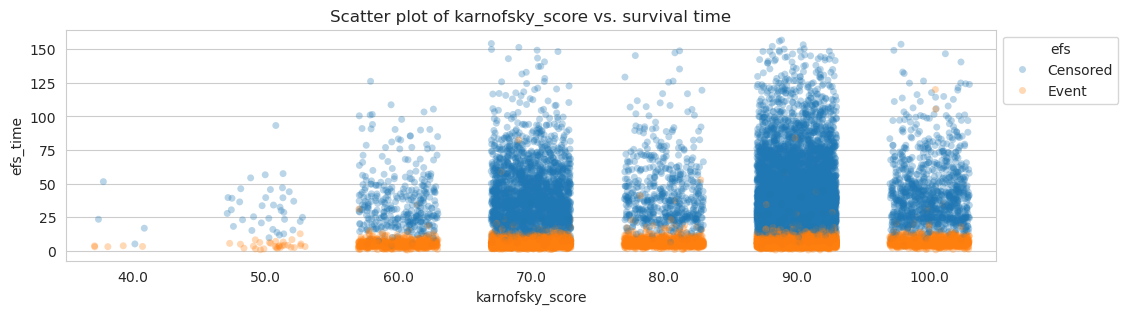

In [91]:
hist_by_efs('karnofsky_score', discrete=False, bins=range(35, 115, 10))
scatter_by_efs_discrete('karnofsky_score')

##### hla_match_drb1_high

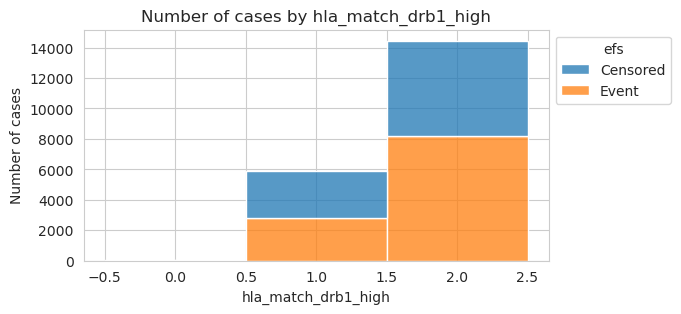

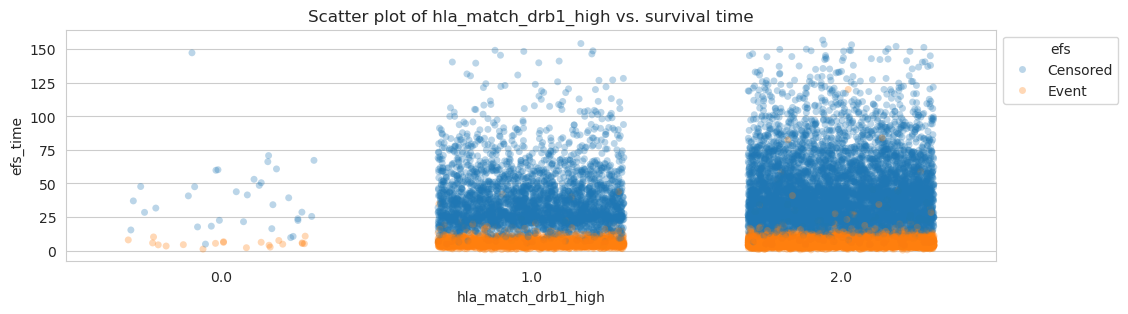

In [92]:
hist_by_efs('hla_match_drb1_high', discrete=True)
scatter_by_efs_discrete('hla_match_drb1_high')

##### hla_high_res_10

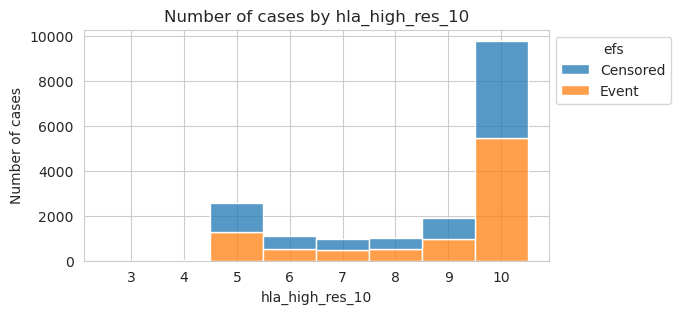

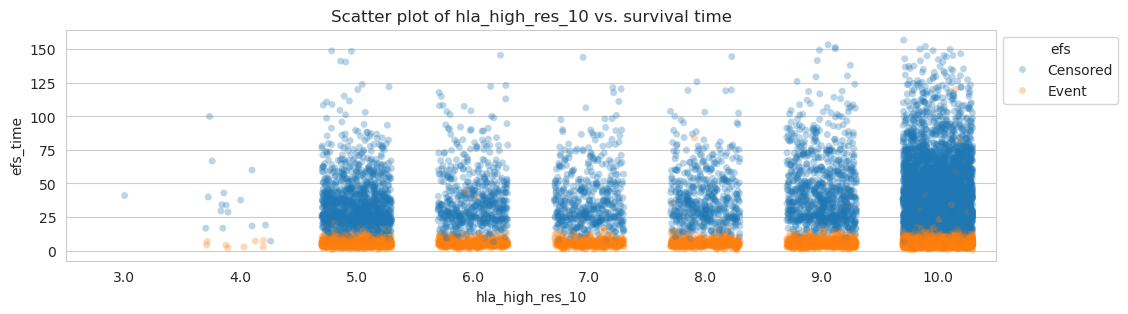

In [ ]:
hist_by_efs('hla_high_res_10', discrete=True)
scatter_by_efs_discrete('hla_high_res_10')

##### race_group

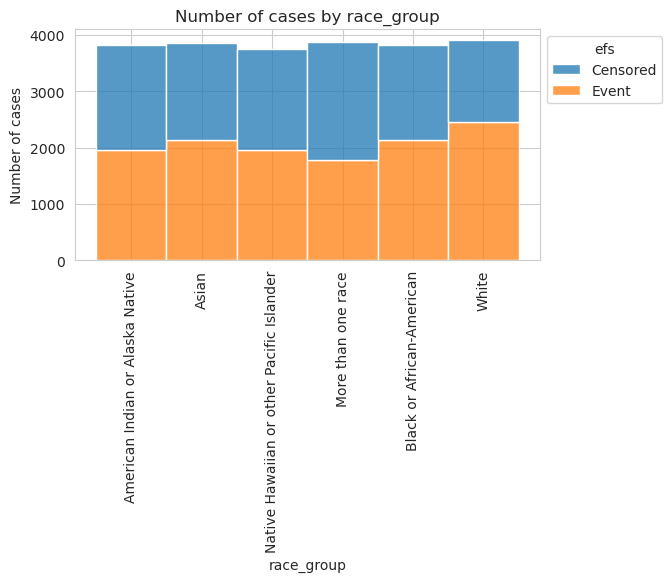

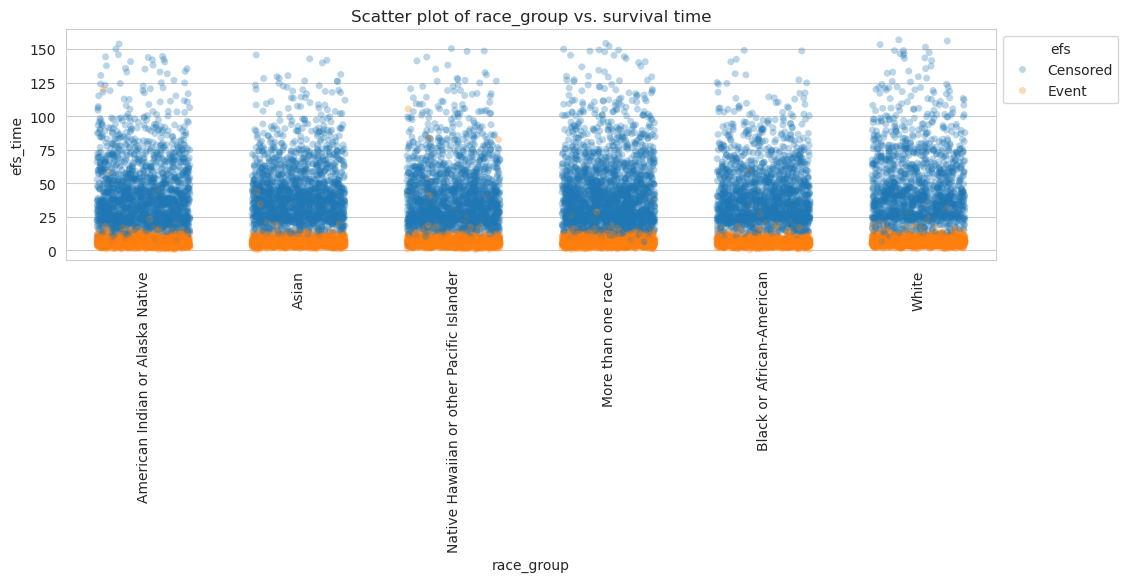

In [94]:
hist_by_efs('race_group', tick_angle=90)
scatter_by_efs_discrete('race_group', tick_angle=90)

#### Main Take-aways

- Based on these plots, it appears that younger patients have better survival outcomes. They are less likely to be recoded as `Event`, and tend to have higher survival times. Pediatric patients especially do well.
- Patients with higher comorbidity scores have worse outcomes, as expected. They are much more likely to be coded as `Event` and have lower survival times.
- Surprisingly, the plots do not show obvious trends based on HLA match or karnofsky score (a measure of day-to-day functioning). These may more informative in combination with other features, of the trends may be too subtle to be obvious on a plot.

#### Experiments with Lifelines

In [ ]:
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()

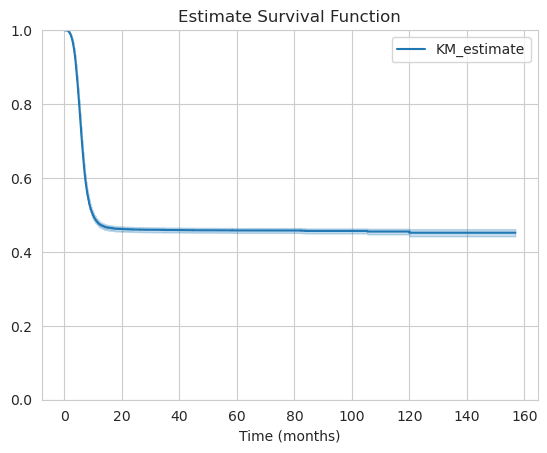

Median survival time:  9.941


In [18]:
df = pd.read_csv("../data/train_set.csv")
T = df['efs_time']
E = df['efs']
kmf.fit(T, event_observed=E)

ax = kmf.plot_survival_function()
ax.set_title("Estimate Survival Function")
ax.set_xlabel("Time (months)")
ax.set_ylim(0.0, 1.0)
plt.show()
print("Median survival time: ", kmf.median_survival_time_)

In [20]:
df.race_group.value_counts()

race_group
White                                        3905
More than one race                           3878
Asian                                        3865
American Indian or Alaska Native             3827
Black or African-American                    3821
Native Hawaiian or other Pacific Islander    3744
Name: count, dtype: int64

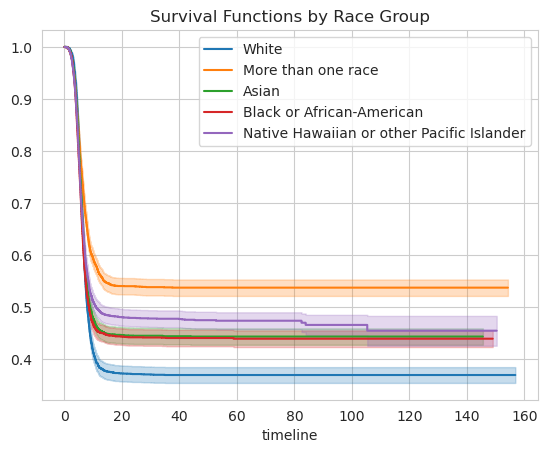

In [50]:
df_white = df[df["race_group"] == "White"]
df_multi = df[df["race_group"] == "More than one race"]
df_asian = df[df["race_group"] == "Asian"]
df_aa = df[df["race_group"] == "Black or African-American"]
df_islander = df[df["race_group"] == "Native Hawaiian or other Pacific Islander"]

ax = plt.subplot()
kmf.fit(df_white['efs_time'], event_observed=df_white["efs"], label="White")
kmf.plot_survival_function(ax=ax)

kmf.fit(df_multi['efs_time'], event_observed=df_multi["efs"], label="More than one race")
kmf.plot_survival_function(ax=ax)

kmf.fit(df_asian['efs_time'], event_observed=df_asian["efs"], label="Asian")
kmf.plot_survival_function(ax=ax)

kmf.fit(df_aa['efs_time'], event_observed=df_aa["efs"], label="Black or African-American")
kmf.plot_survival_function(ax=ax)

kmf.fit(df_islander['efs_time'], event_observed=df_islander['efs'], 
        label="Native Hawaiian or other Pacific Islander")
kmf.plot_survival_function(ax=ax)

plt.title("Survival Functions by Race Group")
plt.show()

In [37]:
from lifelines.statistics import multivariate_logrank_test, pairwise_logrank_test
result = multivariate_logrank_test(df["efs_time"], df["race_group"], df["efs"])
result.summary

,test_statistic,p,-log2(p)
0,211.054308,1.223793e-43,142.551549


In [39]:
result = pairwise_logrank_test(df["efs_time"], df["race_group"], df["efs"])
result.summary

test_statistic  ...    -log2(p)
American Indian or Alaska Native          Asian                                           14.179474  ...   12.555023
                                          Black or African-American                       22.139244  ...   18.589169
                                          More than one race                              23.267289  ...   19.436105
                                          Native Hawaiian or other Pacific Islander        2.279315  ...    2.931153
                                          White                                           80.218334  ...   61.371430
Asian                                     Black or African-American                        1.078747  ...    1.741889
                                          More than one race                              74.055063  ...   56.869311
                                          Native Hawaiian or other Pacific Islander        4.536760  ...    4.913789
                                          White                                           24.782935  ...   20.571755
Black or African-American                 More than one race                              88.919890  ...   67.720899
                                          Native Hawaiian or other Pacific Islander        9.511408  ...    8.935812
                                          White                                           14.403620  ...   12.726817
More than one race                        Native Hawaiian or other Pacific Islander       38.421349  ...   30.708184
                                          White                                          197.386142  ...  146.529409
Native Hawaiian or other Pacific Islander White                                           50.492527  ...   39.604685

[15 rows x 3 columns]

In [60]:
def plot_by_group(feat_name, df = df):
    ax = plt.subplot()

    vals = df[feat_name].dropna().unique()
    vals.sort()
    
    duration = df['efs_time']
    event = df['efs']

    for val in vals:
        mask = (df[feat_name] == val)
        kmf.fit(duration[mask], event[mask], label = val)
        kmf.plot_survival_function(ax=ax)

    plt.title("Survival functions by {}".format(feat_name))
    plt.show()

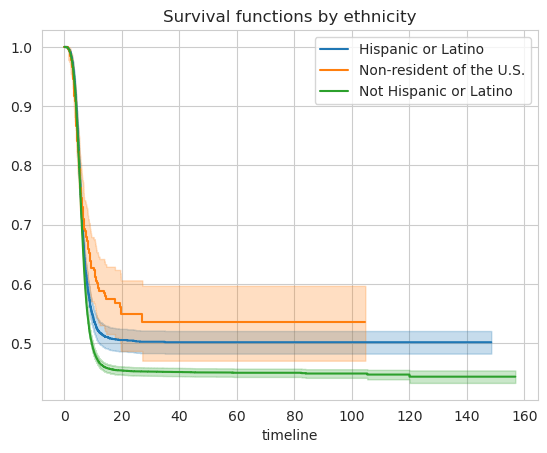

In [93]:
plot_by_group('ethnicity')

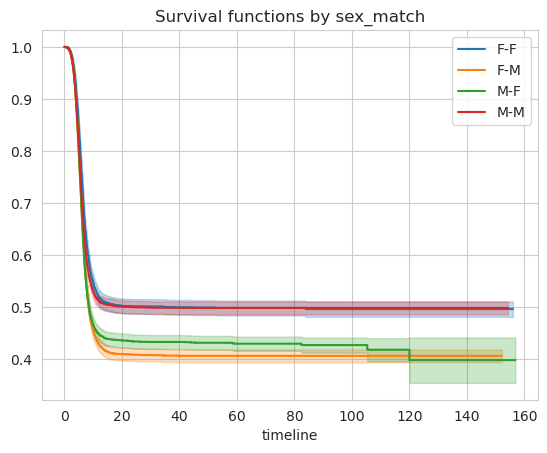

In [94]:
plot_by_group('sex_match')